### Identificação de Erros de Cadastro de Potência

Analisem a relação entre a potência cadastrada de cada usina e sua
geração efetiva ao longo da sua existência. Utilizem análises
comparativas e algoritmos de detecção de anomalias para identificar
usinas cuja geração não corresponde ao valor de potência registrado.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
DATASETS_FOLDER = './datasets/'

In [3]:
df_geracao = pd.read_csv(DATASETS_FOLDER + 'geracao', chunksize=1000000)
df_usina = pd.read_csv(DATASETS_FOLDER + '/usina')

In [4]:
# Removendo os dados ausentes da coluna potencia
df_usina.dropna(subset=['potencia'], inplace=True)

# Removendo a coluna last_plant_history_id
df_usina.drop(columns=['last_plant_history_id'], inplace=True)

In [5]:
# Selecionando 100000 dados de amostra
df_usina_amostra = df_usina.sample(n=100000, random_state=42)

# IDs usinas
ids_usinas_amostra = df_usina_amostra['id'].tolist()

In [6]:
geracao_filtrada = []

for chunk in df_geracao:
    # Filtrar dados de geracao das usinas amostra
    chunk_filtrado = chunk[chunk['id_usina'].isin(ids_usinas_amostra)]

    # Adicionar o chunk filtrado à lista
    geracao_filtrada.append(chunk_filtrado)

# Concatenar todos os chunks filtrados em um único DataFrame
df_geracao_filtrada = pd.concat(geracao_filtrada, ignore_index=True)

In [8]:
df_geracao_filtrada.dropna(subset=['quantidade', 'prognostico'], inplace=True)

Caso a usina esteja gerando muito acima do prognóstico (geração 20% maior que o prognóstico), ou muito baixo (geração menor que 70% do prognóstico) em um determinado período de tempo é possível que a usina esteja com algum problema ou que os dados de cadastro de potência da usina ou de prognóstico estejam incorretos

In [9]:
# Calcular a média de geração e prognóstico por usina
media_geracao_prognostico = (
    df_geracao_filtrada.groupby('id_usina')[['quantidade', 'prognostico']]
    .mean()
    .reset_index()
    .rename(columns={
        'quantidade': 'media_geracao_diaria',
        'prognostico': 'media_prognostico_diaria'
    })
)

# Combinar dados
dados = pd.merge(df_usina, media_geracao_prognostico, left_on='id', right_on='id_usina')
dados['eficiencia'] = dados['media_geracao_diaria'] / dados['potencia']
dados['desempenho_vs_prognostico'] = dados['media_geracao_diaria'] / dados['media_prognostico_diaria']

### Identificar erros de cadastro

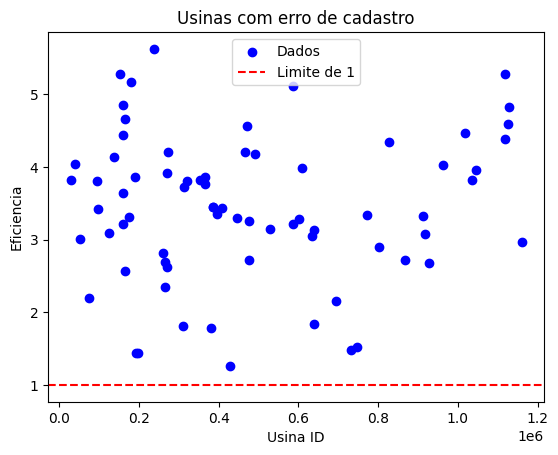

,id,potencia,unidade_consumidora_id,id_usina,media_geracao_diaria,media_prognostico_diaria,eficiencia,desempenho_vs_prognostico
0,475968,9.90,546249,475968,32.171053,32.741667,3.249601,0.982572
1,446631,8.00,512499,446631,26.404966,26.337111,3.300621,1.002576
2,264909,45.00,297484,264909,105.586957,148.256522,2.346377,0.712191
3,428212,11.10,490704,428212,13.960544,36.735238,1.257707,0.380031
4,827162,2.72,941555,827162,11.801676,8.876648,4.338851,1.329519


In [16]:
erros_cadastro = dados[dados['media_geracao_diaria'] > dados['potencia']][:80]

plt.scatter(erros_cadastro['id'], erros_cadastro['eficiencia'], label='Dados', color='b')

plt.axhline(y=1, color='r', linestyle='--', label='Limite de 1')

plt.title('Usinas com erro de cadastro')
plt.xlabel('Usina ID')
plt.ylabel('Eficiencia')
plt.legend()

plt.show()

erros_cadastro.head()

### Usinas para manutenção

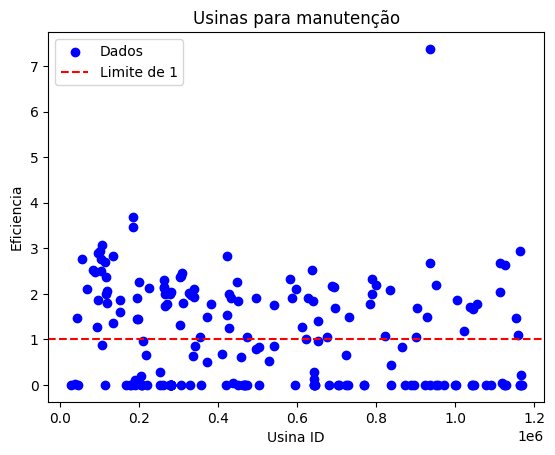

In [14]:
usinas_para_manutencao = dados[
    (dados['media_geracao_diaria'] <= 0.7) | 
    (dados['desempenho_vs_prognostico'] < 0.7)
][:200]

plt.scatter(usinas_para_manutencao['id'], usinas_para_manutencao['eficiencia'], label='Dados', color='b')
plt.axhline(y=1, color='r', linestyle='--', label='Limite de 1')

plt.title('Usinas para manutenção')
plt.xlabel('Usina ID')
plt.ylabel('Eficiencia')
plt.legend()

plt.show()

### Usinas com geração abaixo ou acima do esperado pelo prognóstico

In [73]:
usinas_abaixo_prognostico = dados[dados['desempenho_vs_prognostico'] < 0.7]
usinas_acima_prognostico = dados[dados['desempenho_vs_prognostico'] > 1.2]

print('Abaixo do esperado')
display(usinas_abaixo_prognostico.head())

print('Acima do esperado')
display(usinas_acima_prognostico.head())

Abaixo do esperado


,id,potencia,unidade_consumidora_id,id_usina,media_geracao_diaria,media_prognostico_diaria,eficiencia,desempenho_vs_prognostico,eficiencia_esperada,prognostico_esperado,sem_erros
3,428212,11.1,490704,428212,13.960544,36.735238,1.257707,0.380031,False,False,False
8,693568,12.0,777108,693568,25.911354,41.047801,2.159279,0.631248,False,False,False
10,197602,13.0,222541,197602,18.699837,42.723659,1.438449,0.437693,False,False,False
11,1166673,60.0,1343617,1166673,12.624390,195.101707,0.210407,0.064707,False,False,True
18,166503,3.7,187733,166503,0.000000,10.856116,0.000000,0.000000,False,False,True


Acima do esperado


,id,potencia,unidade_consumidora_id,id_usina,media_geracao_diaria,media_prognostico_diaria,eficiencia,desempenho_vs_prognostico,eficiencia_esperada,prognostico_esperado,sem_erros
4,827162,2.72,941555,827162,11.801676,8.876648,4.338851,1.329519,False,False,False
5,490444,10.90,563385,490444,45.576336,35.750534,4.181315,1.274843,False,False,False
6,165440,6.00,186606,165440,27.920606,19.706485,4.653434,1.416823,False,False,False
12,315873,0.00,357597,315873,38.893103,0.000000,inf,inf,False,False,False
14,160537,3.00,181073,160537,14.566272,9.623195,4.855424,1.513663,False,False,False


### Usinas com resultados corretos e esperados

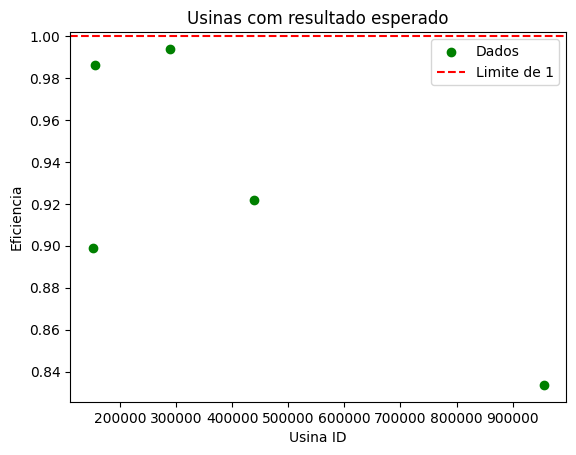

In [69]:
# Usinas corretas
dados['eficiencia_esperada'] = (dados['eficiencia'] >= 0.7) & (dados['eficiencia'] <= 1.0)
dados['prognostico_esperado'] = (dados['desempenho_vs_prognostico'] >= 0.9) & (dados['desempenho_vs_prognostico'] <= 1.1)
dados['sem_erros'] = dados['media_geracao_diaria'] <= dados['potencia']

usinas_corretas = dados[
    dados['eficiencia_esperada'] &
    dados['prognostico_esperado'] &
    dados['sem_erros']
]

plt.scatter(usinas_corretas['id'], usinas_corretas['eficiencia'], label='Dados', color='g')

plt.axhline(y=1, color='r', linestyle='--', label='Limite de 1')

plt.title('Usinas com resultado esperado')
plt.xlabel('Usina ID')
plt.ylabel('Eficiencia')
plt.legend()

plt.show()